In [1]:
!pip install snowflake-snowpark-python
!pip install "snowflake-snowpark-python[pandas]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.7/419.7 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 kB 9.2 MB/s eta 0:00:00


In [2]:
from google.colab import files
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.stattools import jarque_bera
from statsmodels.graphics.api import plot_leverage_resid2, influence_plot
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from snowflake.snowpark import Session
from snowflake.snowpark import functions as F
from snowflake.snowpark.functions import year, month,avg
from snowflake.snowpark.functions import count, col, when,lit
from snowflake.snowpark.functions import min as sp_min, count, sum as sp_sum
from snowflake.snowpark.types import IntegerType, FloatType, DoubleType, DecimalType, StringType, DateType, TimestampType, LongType
import datetime

In [3]:
uploaded = files.upload()

Saving gdp_norm_monthly_agg.csv to gdp_norm_monthly_agg.csv
Saving general_cpi_monthly_agg.csv to general_cpi_monthly_agg.csv
Saving Household_debt_yearly_agg.csv to Household_debt_yearly_agg.csv


In [4]:
df_gdp_norm_monthly = pd.read_csv('gdp_norm_monthly_agg.csv')
df_cpi_monthly = pd.read_csv('general_cpi_monthly_agg.csv')
df_debt = pd.read_csv('Household_debt_yearly_agg.csv')

#**Prepare Macro DATA**#
Aggregate
Standardize
Merge

# GDP Normalized

In [5]:
df_gdp_norm_monthly

,EXTRACTIONDATE,OBSERVATION_DATE,GDP_NORMALIZED,YEAR,MONTH,LIKELIHOODOFDEFAULT
0,2024-03-31,2006-01-01,100.776983,2006,1,0.019363
1,2024-03-31,2006-02-01,100.804387,2006,2,0.017998
2,2024-03-31,2006-03-01,100.858167,2006,3,0.036930
3,2024-03-31,2006-04-01,100.934271,2006,4,0.036691
4,2024-03-31,2006-05-01,101.023159,2006,5,0.026561
...,...,...,...,...,...,...
186,2024-03-31,2021-07-01,100.708930,2021,7,0.144391
187,2024-03-31,2021-08-01,101.208495,2021,8,0.166013
188,2024-03-31,2021-09-01,101.663892,2021,9,0.157074
189,2024-03-31,2021-10-01,102.068399,2021,10,0.139014


In [6]:
# Aggregate by Year
df_gdp_norm = df_gdp_norm_monthly.groupby('YEAR')[['GDP_NORMALIZED','LIKELIHOODOFDEFAULT']].mean().reset_index()
df_gdp_norm.columns = ['YEAR', 'GDP_NORMALIZED', 'Default']
df_gdp_norm

,YEAR,GDP_NORMALIZED,Default
0,2006,101.183413,0.031147
1,2007,101.468835,0.048223
2,2008,100.991230,0.057578
3,2009,97.966464,0.065099
4,2010,99.035276,0.094541
5,2011,100.079240,0.100884
6,2012,100.863203,0.107263
7,2013,101.092995,0.066995
8,2014,100.393099,0.073519
9,2015,100.187323,0.081137


In [7]:
# Standardizing
scaler = StandardScaler()
df_gdp_norm['GDP_standardized'] = scaler.fit_transform(df_gdp_norm[['GDP_NORMALIZED']])

# Converting default rate to percentage
df_gdp_norm['Default%'] = df_gdp_norm['Default'] * 100

In [8]:
df_gdp_norm

,YEAR,GDP_NORMALIZED,Default,GDP_standardized,Default%
0,2006,101.183413,0.031147,0.828314,3.114750
1,2007,101.468835,0.048223,1.021430,4.822267
2,2008,100.991230,0.057578,0.698284,5.757800
3,2009,97.966464,0.065099,-1.348267,6.509900
4,2010,99.035276,0.094541,-0.625111,9.454142
5,2011,100.079240,0.100884,0.081233,10.088433
6,2012,100.863203,0.107263,0.611661,10.726350
7,2013,101.092995,0.066995,0.767137,6.699517
8,2014,100.393099,0.073519,0.293589,7.351858
9,2015,100.187323,0.081137,0.154362,8.113717


In [9]:
df_gdp_norm = df_gdp_norm[['YEAR', 'GDP_standardized', 'Default%']]
df_gdp_norm

,YEAR,GDP_standardized,Default%
0,2006,0.828314,3.114750
1,2007,1.021430,4.822267
2,2008,0.698284,5.757800
3,2009,-1.348267,6.509900
4,2010,-0.625111,9.454142
5,2011,0.081233,10.088433
6,2012,0.611661,10.726350
7,2013,0.767137,6.699517
8,2014,0.293589,7.351858
9,2015,0.154362,8.113717


# CPI

In [10]:
df_cpi_monthly

,EXTRACTIONDATE,REG,Descripción series,Date (varchar),Date (#),IPC,YEAR,MONTH,LIKELIHOODOFDEFAULT,DATE
0,2024-03-21 21:55:32.380,1.0,IPC general (empalme BCCh),Jan.2009,2009-01-01,59.05,2009,1,0.052036,2009-01-01
1,2024-03-21 21:55:32.380,1.0,IPC general (empalme BCCh),Feb.2009,2009-02-01,58.28,2009,2,0.050888,2009-02-01
2,2024-03-21 21:55:32.380,1.0,IPC general (empalme BCCh),Mar.2009,2009-03-01,58.30,2009,3,0.050589,2009-03-01
3,2024-03-21 21:55:32.380,1.0,IPC general (empalme BCCh),Apr.2009,2009-04-01,58.21,2009,4,0.058679,2009-04-01
4,2024-03-21 21:55:32.380,1.0,IPC general (empalme BCCh),May.2009,2009-05-01,58.09,2009,5,0.065349,2009-05-01
...,...,...,...,...,...,...,...,...,...,...
176,2024-03-21 21:55:32.380,1.0,IPC general (empalme BCCh),Sep.2023,2023-09-01,100.53,2023,9,0.293259,2023-09-01
177,2024-03-21 21:55:32.380,1.0,IPC general (empalme BCCh),Oct.2023,2023-10-01,100.82,2023,10,0.267782,2023-10-01
178,2024-03-21 21:55:32.380,1.0,IPC general (empalme BCCh),Nov.2023,2023-11-01,101.58,2023,11,0.360104,2023-11-01
179,2024-03-21 21:55:32.380,1.0,IPC general (empalme BCCh),Dec.2023,2023-12-01,101.04,2023,12,0.439466,2023-12-01


In [11]:
# Aggregate by Year
df_cpi = df_cpi_monthly.groupby('YEAR')[['IPC','LIKELIHOODOFDEFAULT']].mean().reset_index()
df_cpi.columns = ['YEAR', 'CPI', 'Default']
df_cpi

,YEAR,CPI,Default
0,2009,58.250833,0.065099
1,2010,59.073333,0.094541
2,2011,61.045833,0.100884
3,2012,62.880000,0.107263
4,2013,64.095000,0.066995
5,2014,66.911667,0.073519
6,2015,69.823333,0.081137
7,2016,72.466667,0.097418
8,2017,74.048333,0.097344
9,2018,75.761667,0.097419


In [12]:
# Standardizing
scaler = StandardScaler()
df_cpi['CPI_standardized'] = scaler.fit_transform(df_cpi[['CPI']])

# Converting default rate to percentage
df_cpi['Default%'] = df_cpi['Default'] * 100

In [13]:
df_cpi

,YEAR,CPI,Default,CPI_standardized,Default%
0,2009,58.250833,0.065099,-1.251736,6.509900
1,2010,59.073333,0.094541,-1.190261,9.454142
2,2011,61.045833,0.100884,-1.042833,10.088433
3,2012,62.880000,0.107263,-0.905744,10.726350
4,2013,64.095000,0.066995,-0.814932,6.699517
5,2014,66.911667,0.073519,-0.604409,7.351858
6,2015,69.823333,0.081137,-0.386786,8.113717
7,2016,72.466667,0.097418,-0.189218,9.741817
8,2017,74.048333,0.097344,-0.071001,9.734392
9,2018,75.761667,0.097419,0.057057,9.741892


In [14]:
df_cpi = df_cpi[['YEAR', 'CPI_standardized', 'Default%']]
df_cpi

,YEAR,CPI_standardized,Default%
0,2009,-1.251736,6.509900
1,2010,-1.190261,9.454142
2,2011,-1.042833,10.088433
3,2012,-0.905744,10.726350
4,2013,-0.814932,6.699517
5,2014,-0.604409,7.351858
6,2015,-0.386786,8.113717
7,2016,-0.189218,9.741817
8,2017,-0.071001,9.734392
9,2018,0.057057,9.741892


# Household Debt

In [15]:
df_debt

,EXTRACTIONDATE,COUNTRY,YEAR,DATE,Debt(%GDP),LIKELIHOODOFDEFAULT
0,2024-03-23,Chile,2006,2006-12-31,26.392439,0.032722
1,2024-03-23,Chile,2007,2007-12-31,29.027133,0.048319
2,2024-03-23,Chile,2008,2008-12-31,32.631886,0.057514
3,2024-03-23,Chile,2009,2009-12-31,33.905979,0.065448
4,2024-03-23,Chile,2010,2010-12-31,32.583076,0.094427
5,2024-03-23,Chile,2011,2011-12-31,33.805600,0.101237
6,2024-03-23,Chile,2012,2012-12-31,35.339992,0.107576
7,2024-03-23,Chile,2013,2013-12-31,37.279834,0.068015
8,2024-03-23,Chile,2014,2014-12-31,39.367669,0.074191
9,2024-03-23,Chile,2015,2015-12-31,41.261339,0.081544


In [16]:
# Standardizing
scaler = StandardScaler()
df_debt['Debt_standardized'] = scaler.fit_transform(df_debt[['Debt(%GDP)']])

# Converting default rate to percentage
df_debt['Default%'] = df_debt['LIKELIHOODOFDEFAULT'] * 100

In [17]:
df_debt

,EXTRACTIONDATE,COUNTRY,YEAR,DATE,Debt(%GDP),LIKELIHOODOFDEFAULT,Debt_standardized,Default%
0,2024-03-23,Chile,2006,2006-12-31,26.392439,0.032722,-1.878668,3.2722
1,2024-03-23,Chile,2007,2007-12-31,29.027133,0.048319,-1.482802,4.8319
2,2024-03-23,Chile,2008,2008-12-31,32.631886,0.057514,-0.941184,5.7514
3,2024-03-23,Chile,2009,2009-12-31,33.905979,0.065448,-0.749750,6.5448
4,2024-03-23,Chile,2010,2010-12-31,32.583076,0.094427,-0.948517,9.4427
5,2024-03-23,Chile,2011,2011-12-31,33.805600,0.101237,-0.764832,10.1237
6,2024-03-23,Chile,2012,2012-12-31,35.339992,0.107576,-0.534287,10.7576
7,2024-03-23,Chile,2013,2013-12-31,37.279834,0.068015,-0.242824,6.8015
8,2024-03-23,Chile,2014,2014-12-31,39.367669,0.074191,0.070876,7.4191
9,2024-03-23,Chile,2015,2015-12-31,41.261339,0.081544,0.355402,8.1544


In [18]:
df_debt = df_debt[['YEAR', 'Debt_standardized', 'Default%']]
df_debt

,YEAR,Debt_standardized,Default%
0,2006,-1.878668,3.2722
1,2007,-1.482802,4.8319
2,2008,-0.941184,5.7514
3,2009,-0.749750,6.5448
4,2010,-0.948517,9.4427
5,2011,-0.764832,10.1237
6,2012,-0.534287,10.7576
7,2013,-0.242824,6.8015
8,2014,0.070876,7.4191
9,2015,0.355402,8.1544


# Merge

In [19]:
# Create dfs
dfs = [df_gdp_norm, df_cpi, df_debt]
merged_df = dfs[0]
for df in dfs[1:]:
    merged_df = pd.merge(merged_df, df, on='YEAR', how='outer')

In [20]:
merged_df

,YEAR,GDP_standardized,Default%_x,CPI_standardized,Default%_y,Debt_standardized,Default%
0,2006,0.828314,3.114750,NaN,NaN,-1.878668,3.2722
1,2007,1.021430,4.822267,NaN,NaN,-1.482802,4.8319
2,2008,0.698284,5.757800,NaN,NaN,-0.941184,5.7514
3,2009,-1.348267,6.509900,-1.251736,6.509900,-0.749750,6.5448
4,2010,-0.625111,9.454142,-1.190261,9.454142,-0.948517,9.4427
5,2011,0.081233,10.088433,-1.042833,10.088433,-0.764832,10.1237
6,2012,0.611661,10.726350,-0.905744,10.726350,-0.534287,10.7576
7,2013,0.767137,6.699517,-0.814932,6.699517,-0.242824,6.8015
8,2014,0.293589,7.351858,-0.604409,7.351858,0.070876,7.4191
9,2015,0.154362,8.113717,-0.386786,8.113717,0.355402,8.1544


In [21]:
merged_df = merged_df[['YEAR', 'GDP_standardized', 'CPI_standardized', 'Debt_standardized']]

In [22]:
merged_df

,YEAR,GDP_standardized,CPI_standardized,Debt_standardized
0,2006,0.828314,NaN,-1.878668
1,2007,1.021430,NaN,-1.482802
2,2008,0.698284,NaN,-0.941184
3,2009,-1.348267,-1.251736,-0.749750
4,2010,-0.625111,-1.190261,-0.948517
5,2011,0.081233,-1.042833,-0.764832
6,2012,0.611661,-0.905744,-0.534287
7,2013,0.767137,-0.814932,-0.242824
8,2014,0.293589,-0.604409,0.070876
9,2015,0.154362,-0.386786,0.355402


#**Prepare User Group**#
Aggreate by year of joining

# Aggreate by year of joining

In [23]:
parameters = {
...    "account": "YEZEPEO-DATASCIENCE",
...    "user": "VNSHARED",
...    "password": "Columbia2024!",
...    "role": "SYSADMIN", # optional
...    "warehouse": "ANALYSIS", # optional
...   "database": "MEIXI_DATA", # optional
...   "schema":"PUBLIC",  # optional
...  }
session= Session.builder.configs(parameters).create()

In [24]:
df_v=session.sql('select * from USERS_INDIVIDUAL_DATES_AND_DEFAULTS')

In [25]:
df_v.show(5)

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"BUSINESSPARTNERID"  |"FIRST_YEAR"  |"2006"  |"2007"  |"2008"  |"2009"  |"2010"  |"2011"  |"2012"  |"2013"  |"2014"  |"2015"  |"2016"  |"2017"  |"2018"  |"2019"  |"2020"  |"2021"           |"2022"  |"2023"           |
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|0013762740           |2022          |NULL    |NULL    |NULL    |NULL    |NULL    |NULL    |NULL    |NULL    |NULL    |NULL    |NULL    |NULL    |NULL    |NULL    |NULL    |NULL             |0E-12   |0E-12            |
|0013762743           |2022          |NULL    |NULL    |NULL    |NULL    |NULL    |NULL    |NULL    |NULL    |NULL    |NULL 

In [26]:
# Manually specify the aggregation for each year
aggregated_df = df_v.group_by("FIRST_YEAR").agg(
    avg(col("2006")).alias('avg_2006'),
    avg(col("2007")).alias('avg_2007'),
    avg(col("2008")).alias('avg_2008'),
    avg(col("2009")).alias('avg_2009'),
    avg(col("2010")).alias('avg_2010'),
    avg(col("2011")).alias('avg_2011'),
    avg(col("2012")).alias('avg_2012'),
    avg(col("2013")).alias('avg_2013'),
    avg(col("2014")).alias('avg_2014'),
    avg(col("2015")).alias('avg_2015'),
    avg(col("2016")).alias('avg_2016'),
    avg(col("2017")).alias('avg_2017'),
    avg(col("2018")).alias('avg_2018'),
    avg(col("2019")).alias('avg_2019'),
    avg(col("2020")).alias('avg_2020'),
    avg(col("2021")).alias('avg_2021'),
    avg(col("2022")).alias('avg_2022'),
    avg(col("2023")).alias('avg_2023')
)

# Convert to Pandas DataFrame for plotting
pandas_df = aggregated_df.to_pandas()

# Display the DataFrame to verify
print(pandas_df.head())

   FIRST_YEAR  AVG_2006  AVG_2007  AVG_2008  AVG_2009  AVG_2010   AVG_2011  \
0        2007       NaN  5.760862  4.826286  5.529813  6.985947  13.797318   
1        2012       NaN       NaN       NaN       NaN       NaN        NaN   
2        2015       NaN       NaN       NaN       NaN       NaN        NaN   
3        2017       NaN       NaN       NaN       NaN       NaN        NaN   
4        2022       NaN       NaN       NaN       NaN       NaN        NaN   

   AVG_2012  AVG_2013   AVG_2014   AVG_2015   AVG_2016   AVG_2017   AVG_2018  \
0  9.284582  7.607714   8.468626   7.868423  10.658617  10.534399   9.373776   
1  8.691095  9.591516  11.365129  18.237651  16.054301  15.229697  15.009569   
2       NaN       NaN        NaN  10.159325  13.801417  12.769527  19.996981   
3       NaN       NaN        NaN        NaN        NaN  11.469216  12.079690   
4       NaN       NaN        NaN        NaN        NaN        NaN        NaN   

    AVG_2019   AVG_2020   AVG_2021   AVG_2022   AV

In [27]:
pandas_df

,FIRST_YEAR,AVG_2006,AVG_2007,AVG_2008,AVG_2009,AVG_2010,AVG_2011,AVG_2012,AVG_2013,AVG_2014,AVG_2015,AVG_2016,AVG_2017,AVG_2018,AVG_2019,AVG_2020,AVG_2021,AVG_2022,AVG_2023
0,2007,NaN,5.760862,4.826286,5.529813,6.985947,13.797318,9.284582,7.607714,8.468626,7.868423,10.658617,10.534399,9.373776,10.377951,11.419328,9.810332,11.192152,16.235988
1,2012,NaN,NaN,NaN,NaN,NaN,NaN,8.691095,9.591516,11.365129,18.237651,16.054301,15.229697,15.009569,17.159733,16.425871,15.543569,17.591850,23.513104
2,2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.159325,13.801417,12.769527,19.996981,15.007647,16.384216,16.367442,18.278501,24.425204
3,2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.469216,12.079690,14.272228,22.953289,17.579503,20.043132,26.973177
4,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.428365,22.117896
5,2011,NaN,NaN,NaN,NaN,NaN,7.912300,7.924910,10.010526,17.598973,11.927273,14.820385,14.205185,14.647538,15.452848,15.179292,14.702201,16.578500,22.356013
6,2010,NaN,NaN,NaN,NaN,8.869038,7.973302,9.443017,19.259631,13.264254,12.367011,15.197737,15.557601,14.496377,15.600113,15.780100,15.360526,17.192732,23.282732
7,2013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.132518,10.329783,10.902599,19.951086,15.515215,15.153306,15.612122,17.822303,16.117039,18.483241,24.532302
8,2009,NaN,NaN,NaN,7.856493,7.558292,11.684440,13.547492,10.854079,11.965906,10.583689,14.150923,13.484310,12.524111,13.580750,14.372272,13.243536,14.849868,20.621261
9,2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.924433,16.604354,26.686205


In [28]:
df_sorted = pandas_df.sort_values(by='FIRST_YEAR')

In [29]:
df_sorted.set_index(df_sorted.columns[0], inplace=True)

In [30]:
df_sorted

,AVG_2006,AVG_2007,AVG_2008,AVG_2009,AVG_2010,AVG_2011,AVG_2012,AVG_2013,AVG_2014,AVG_2015,AVG_2016,AVG_2017,AVG_2018,AVG_2019,AVG_2020,AVG_2021,AVG_2022,AVG_2023
FIRST_YEAR,,,,,,,,,,,,,,,,,,
2006,4.528291,4.100383,4.522153,5.341243,6.079070,11.362324,8.270449,6.403031,7.173756,7.705823,9.302226,9.252123,8.413752,9.208654,9.946572,8.794047,10.208215,14.967449
2007,NaN,5.760862,4.826286,5.529813,6.985947,13.797318,9.284582,7.607714,8.468626,7.868423,10.658617,10.534399,9.373776,10.377951,11.419328,9.810332,11.192152,16.235988
2008,NaN,NaN,7.159173,6.498546,7.991887,14.716808,11.470433,9.719232,10.844552,9.727325,12.970698,12.465942,11.518924,12.512990,13.348022,11.838228,13.554516,18.966238
2009,NaN,NaN,NaN,7.856493,7.558292,11.684440,13.547492,10.854079,11.965906,10.583689,14.150923,13.484310,12.524111,13.580750,14.372272,13.243536,14.849868,20.621261
2010,NaN,NaN,NaN,NaN,8.869038,7.973302,9.443017,19.259631,13.264254,12.367011,15.197737,15.557601,14.496377,15.600113,15.780100,15.360526,17.192732,23.282732
2011,NaN,NaN,NaN,NaN,NaN,7.912300,7.924910,10.010526,17.598973,11.927273,14.820385,14.205185,14.647538,15.452848,15.179292,14.702201,16.578500,22.356013
2012,NaN,NaN,NaN,NaN,NaN,NaN,8.691095,9.591516,11.365129,18.237651,16.054301,15.229697,15.009569,17.159733,16.425871,15.543569,17.591850,23.513104
2013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.132518,10.329783,10.902599,19.951086,15.515215,15.153306,15.612122,17.822303,16.117039,18.483241,24.532302
2014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.356800,10.271859,13.483788,20.410507,14.464831,15.487868,16.677270,17.156898,19.096256,25.568464


In [31]:
df_user = df_sorted.T

In [32]:
df_user.reset_index(drop=False, inplace=True)

In [33]:
df_user

FIRST_YEAR,index,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,AVG_2006,4.528291,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AVG_2007,4.100383,5.760862,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AVG_2008,4.522153,4.826286,7.159173,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AVG_2009,5.341243,5.529813,6.498546,7.856493,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AVG_2010,6.079070,6.985947,7.991887,7.558292,8.869038,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,AVG_2011,11.362324,13.797318,14.716808,11.684440,7.973302,7.912300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,AVG_2012,8.270449,9.284582,11.470433,13.547492,9.443017,7.924910,8.691095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,AVG_2013,6.403031,7.607714,9.719232,10.854079,19.259631,10.010526,9.591516,9.132518,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,AVG_2014,7.173756,8.468626,10.844552,11.965906,13.264254,17.598973,11.365129,10.329783,10.356800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,AVG_2015,7.705823,7.868423,9.727325,10.583689,12.367011,11.927273,18.237651,10.902599,10.271859,10.159325,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
df_user.rename(columns={'index': 'YEAR'}, inplace=True)

In [35]:
new_values = [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
df_user['YEAR'] = new_values

In [36]:
df_user.rename_axis(None, axis=1, inplace=True)

In [37]:
df_user

,YEAR,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,2006,4.528291,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2007,4.100383,5.760862,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2008,4.522153,4.826286,7.159173,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2009,5.341243,5.529813,6.498546,7.856493,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2010,6.079070,6.985947,7.991887,7.558292,8.869038,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2011,11.362324,13.797318,14.716808,11.684440,7.973302,7.912300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2012,8.270449,9.284582,11.470433,13.547492,9.443017,7.924910,8.691095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2013,6.403031,7.607714,9.719232,10.854079,19.259631,10.010526,9.591516,9.132518,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2014,7.173756,8.468626,10.844552,11.965906,13.264254,17.598973,11.365129,10.329783,10.356800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2015,7.705823,7.868423,9.727325,10.583689,12.367011,11.927273,18.237651,10.902599,10.271859,10.159325,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#**Multivariate Regression**#

# Prepare

In [38]:
df_macro_user = pd.merge(merged_df, df_user, on='YEAR', how='outer')

In [39]:
df_macro_user

,YEAR,GDP_standardized,CPI_standardized,Debt_standardized,2006,2007,2008,2009,2010,2011,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,2006,0.828314,NaN,-1.878668,4.528291,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2007,1.021430,NaN,-1.482802,4.100383,5.760862,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2008,0.698284,NaN,-0.941184,4.522153,4.826286,7.159173,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2009,-1.348267,-1.251736,-0.749750,5.341243,5.529813,6.498546,7.856493,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2010,-0.625111,-1.190261,-0.948517,6.079070,6.985947,7.991887,7.558292,8.869038,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2011,0.081233,-1.042833,-0.764832,11.362324,13.797318,14.716808,11.684440,7.973302,7.912300,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2012,0.611661,-0.905744,-0.534287,8.270449,9.284582,11.470433,13.547492,9.443017,7.924910,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2013,0.767137,-0.814932,-0.242824,6.403031,7.607714,9.719232,10.854079,19.259631,10.010526,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2014,0.293589,-0.604409,0.070876,7.173756,8.468626,10.844552,11.965906,13.264254,17.598973,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2015,0.154362,-0.386786,0.355402,7.705823,7.868423,9.727325,10.583689,12.367011,11.927273,...,10.159325,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
df_macro_user.columns = df_macro_user.columns.map(str)

In [41]:
df_macro_user

,YEAR,GDP_standardized,CPI_standardized,Debt_standardized,2006,2007,2008,2009,2010,2011,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,2006,0.828314,NaN,-1.878668,4.528291,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2007,1.021430,NaN,-1.482802,4.100383,5.760862,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2008,0.698284,NaN,-0.941184,4.522153,4.826286,7.159173,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2009,-1.348267,-1.251736,-0.749750,5.341243,5.529813,6.498546,7.856493,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2010,-0.625111,-1.190261,-0.948517,6.079070,6.985947,7.991887,7.558292,8.869038,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2011,0.081233,-1.042833,-0.764832,11.362324,13.797318,14.716808,11.684440,7.973302,7.912300,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2012,0.611661,-0.905744,-0.534287,8.270449,9.284582,11.470433,13.547492,9.443017,7.924910,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2013,0.767137,-0.814932,-0.242824,6.403031,7.607714,9.719232,10.854079,19.259631,10.010526,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2014,0.293589,-0.604409,0.070876,7.173756,8.468626,10.844552,11.965906,13.264254,17.598973,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2015,0.154362,-0.386786,0.355402,7.705823,7.868423,9.727325,10.583689,12.367011,11.927273,...,10.159325,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
df_2006 = df_macro_user[['YEAR', 'GDP_standardized', 'CPI_standardized', 'Debt_standardized', '2006']].rename(columns={'2006': 'Average Default%'}).dropna()
df_2009 = df_macro_user[['YEAR', 'GDP_standardized', 'CPI_standardized', 'Debt_standardized', '2009']].rename(columns={'2009': 'Average Default%'}).dropna()
df_2012 = df_macro_user[['YEAR', 'GDP_standardized', 'CPI_standardized', 'Debt_standardized', '2012']].rename(columns={'2012': 'Average Default%'}).dropna()
df_2015 = df_macro_user[['YEAR', 'GDP_standardized', 'CPI_standardized', 'Debt_standardized', '2015']].rename(columns={'2015': 'Average Default%'}).dropna()
df_2018 = df_macro_user[['YEAR', 'GDP_standardized', 'CPI_standardized', 'Debt_standardized', '2018']].rename(columns={'2018': 'Average Default%'}).dropna()

# 2006

In [43]:
df_2006

,YEAR,GDP_standardized,CPI_standardized,Debt_standardized,Average Default%
3,2009,-1.348267,-1.251736,-0.749750,5.341243
4,2010,-0.625111,-1.190261,-0.948517,6.079070
5,2011,0.081233,-1.042833,-0.764832,11.362324
6,2012,0.611661,-0.905744,-0.534287,8.270449
7,2013,0.767137,-0.814932,-0.242824,6.403031
8,2014,0.293589,-0.604409,0.070876,7.173756
9,2015,0.154362,-0.386786,0.355402,7.705823
10,2016,-0.115416,-0.189218,0.531033,9.302226
11,2017,-0.194398,-0.071001,0.736673,9.252123
12,2018,0.570839,0.057057,1.042763,8.413752


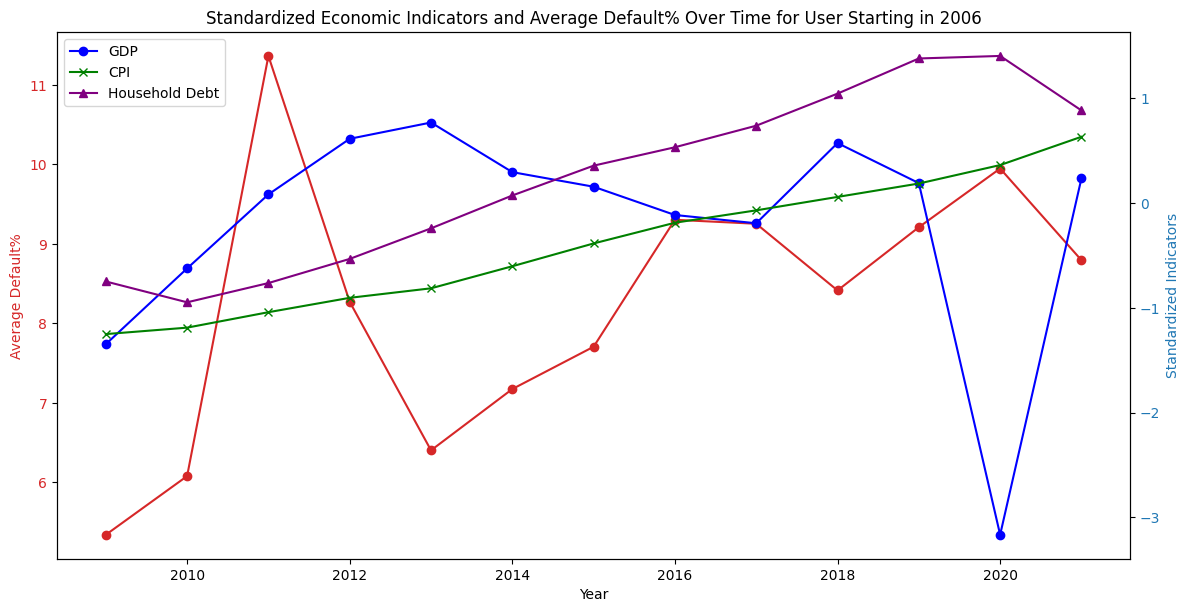

In [44]:
# Set up the plotting graph
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the first variable (Default%):
color = 'tab:red'
ax1.set_xlabel('Year')
ax1.set_ylabel('Average Default%', color=color)
ax1.plot(df_2006['YEAR'], df_2006['Average Default%'], color=color, marker='o')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second axes for the standardized indicators:
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Standardized Indicators', color=color)
ax2.plot(df_2006['YEAR'], df_2006['GDP_standardized'], label='GDP', color='blue', marker='o')
ax2.plot(df_2006['YEAR'], df_2006['CPI_standardized'], label='CPI', color='green', marker='x')
ax2.plot(df_2006['YEAR'], df_2006['Debt_standardized'], label='Household Debt', color='purple', marker='^')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Standardized Economic Indicators and Average Default% Over Time for User Starting in 2006')
ax2.legend(loc='upper left')
ax1.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.show()

In [45]:
# Defining variables
X = df_2006[["GDP_standardized", "CPI_standardized", "Debt_standardized"]]
y = df_2006["Average Default%"]

# Adding a constant to the model (for the intercept)
X = sm.add_constant(X)

# Building the OLS model
model_2006 = sm.OLS(y, X).fit()

# Print the summary of the OLS model
print(model_2006.summary())

                            OLS Regression Results                            
Dep. Variable:       Average Default%   R-squared:                       0.250
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.001
Date:                Fri, 19 Apr 2024   Prob (F-statistic):              0.436
Time:                        14:44:22   Log-Likelihood:                -22.816
No. Observations:                  13   AIC:                             53.63
Df Residuals:                       9   BIC:                             55.89
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 9.0471      1.52

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


# 2009

In [46]:
df_2009

,YEAR,GDP_standardized,CPI_standardized,Debt_standardized,Average Default%
3,2009,-1.348267,-1.251736,-0.749750,7.856493
4,2010,-0.625111,-1.190261,-0.948517,7.558292
5,2011,0.081233,-1.042833,-0.764832,11.684440
6,2012,0.611661,-0.905744,-0.534287,13.547492
7,2013,0.767137,-0.814932,-0.242824,10.854079
8,2014,0.293589,-0.604409,0.070876,11.965906
9,2015,0.154362,-0.386786,0.355402,10.583689
10,2016,-0.115416,-0.189218,0.531033,14.150923
11,2017,-0.194398,-0.071001,0.736673,13.484310
12,2018,0.570839,0.057057,1.042763,12.524111


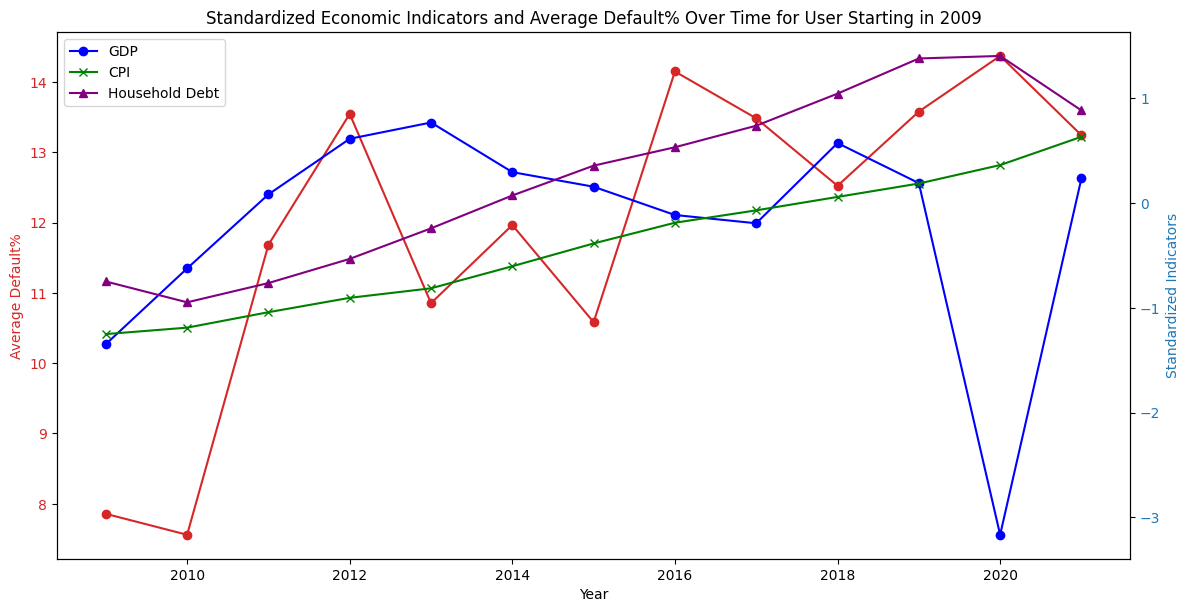

In [47]:
# Set up the plotting graph
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the first variable (Default%):
color = 'tab:red'
ax1.set_xlabel('Year')
ax1.set_ylabel('Average Default%', color=color)
ax1.plot(df_2009['YEAR'], df_2009['Average Default%'], color=color, marker='o')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second axes for the standardized indicators:
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Standardized Indicators', color=color)
ax2.plot(df_2009['YEAR'], df_2009['GDP_standardized'], label='GDP', color='blue', marker='o')
ax2.plot(df_2009['YEAR'], df_2009['CPI_standardized'], label='CPI', color='green', marker='x')
ax2.plot(df_2009['YEAR'], df_2009['Debt_standardized'], label='Household Debt', color='purple', marker='^')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Standardized Economic Indicators and Average Default% Over Time for User Starting in 2009')
ax2.legend(loc='upper left')
ax1.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.show()

In [48]:
# Defining variables
X = df_2009[["GDP_standardized", "CPI_standardized", "Debt_standardized"]]
y = df_2009["Average Default%"]

# Adding a constant to the model (for the intercept)
X = sm.add_constant(X)

# Building the OLS model
model_2009 = sm.OLS(y, X).fit()

# Print the summary of the OLS model
print(model_2009.summary())

                            OLS Regression Results                            
Dep. Variable:       Average Default%   R-squared:                       0.565
Model:                            OLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                     3.899
Date:                Fri, 19 Apr 2024   Prob (F-statistic):             0.0489
Time:                        14:44:22   Log-Likelihood:                -22.916
No. Observations:                  13   AIC:                             53.83
Df Residuals:                       9   BIC:                             56.09
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                12.4377      1.54

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


# 2012

In [49]:
df_2012

,YEAR,GDP_standardized,CPI_standardized,Debt_standardized,Average Default%
6,2012,0.611661,-0.905744,-0.534287,8.691095
7,2013,0.767137,-0.814932,-0.242824,9.591516
8,2014,0.293589,-0.604409,0.070876,11.365129
9,2015,0.154362,-0.386786,0.355402,18.237651
10,2016,-0.115416,-0.189218,0.531033,16.054301
11,2017,-0.194398,-0.071001,0.736673,15.229697
12,2018,0.570839,0.057057,1.042763,15.009569
13,2019,0.188840,0.184803,1.378116,17.159733
14,2020,-3.166652,0.361007,1.402263,16.425871
15,2021,0.234152,0.630950,0.882195,15.543569


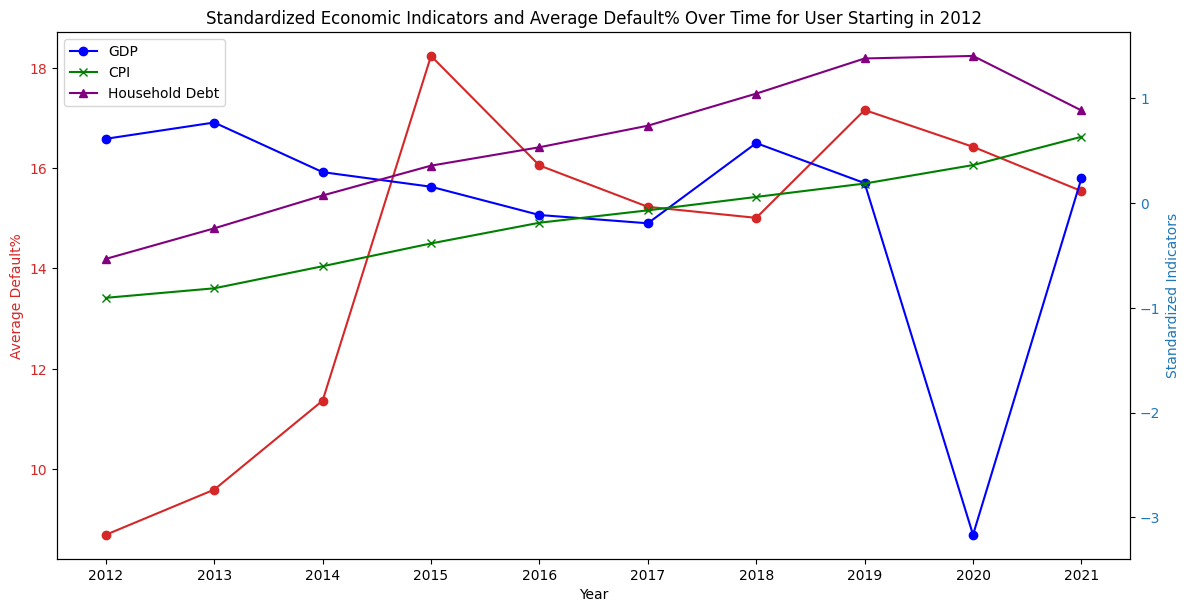

In [50]:
# Set up the plotting graph
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the first variable (Default%):
color = 'tab:red'
ax1.set_xlabel('Year')
ax1.set_ylabel('Average Default%', color=color)
ax1.plot(df_2012['YEAR'], df_2012['Average Default%'], color=color, marker='o')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second axes for the standardized indicators:
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Standardized Indicators', color=color)
ax2.plot(df_2012['YEAR'], df_2012['GDP_standardized'], label='GDP', color='blue', marker='o')
ax2.plot(df_2012['YEAR'], df_2012['CPI_standardized'], label='CPI', color='green', marker='x')
ax2.plot(df_2012['YEAR'], df_2012['Debt_standardized'], label='Household Debt', color='purple', marker='^')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Standardized Economic Indicators and Average Default% Over Time for User Starting in 2012')
ax2.legend(loc='upper left')
ax1.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.show()

In [51]:
# Defining variables
X = df_2012[["GDP_standardized", "CPI_standardized", "Debt_standardized"]]
y = df_2012["Average Default%"]

# Adding a constant to the model (for the intercept)
X = sm.add_constant(X)

# Building the OLS model
model_2012 = sm.OLS(y, X).fit()

# Print the summary of the OLS model
print(model_2012.summary())

                            OLS Regression Results                            
Dep. Variable:       Average Default%   R-squared:                       0.650
Model:                            OLS   Adj. R-squared:                  0.474
Method:                 Least Squares   F-statistic:                     3.706
Date:                Fri, 19 Apr 2024   Prob (F-statistic):             0.0808
Time:                        14:47:13   Log-Likelihood:                -20.278
No. Observations:                  10   AIC:                             48.56
Df Residuals:                       6   BIC:                             49.77
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                12.0899      2.37

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


# 2015

In [52]:
df_2015

,YEAR,GDP_standardized,CPI_standardized,Debt_standardized,Average Default%
9,2015,0.154362,-0.386786,0.355402,10.159325
10,2016,-0.115416,-0.189218,0.531033,13.801417
11,2017,-0.194398,-0.071001,0.736673,12.769527
12,2018,0.570839,0.057057,1.042763,19.996981
13,2019,0.188840,0.184803,1.378116,15.007647
14,2020,-3.166652,0.361007,1.402263,16.384216
15,2021,0.234152,0.630950,0.882195,16.367442


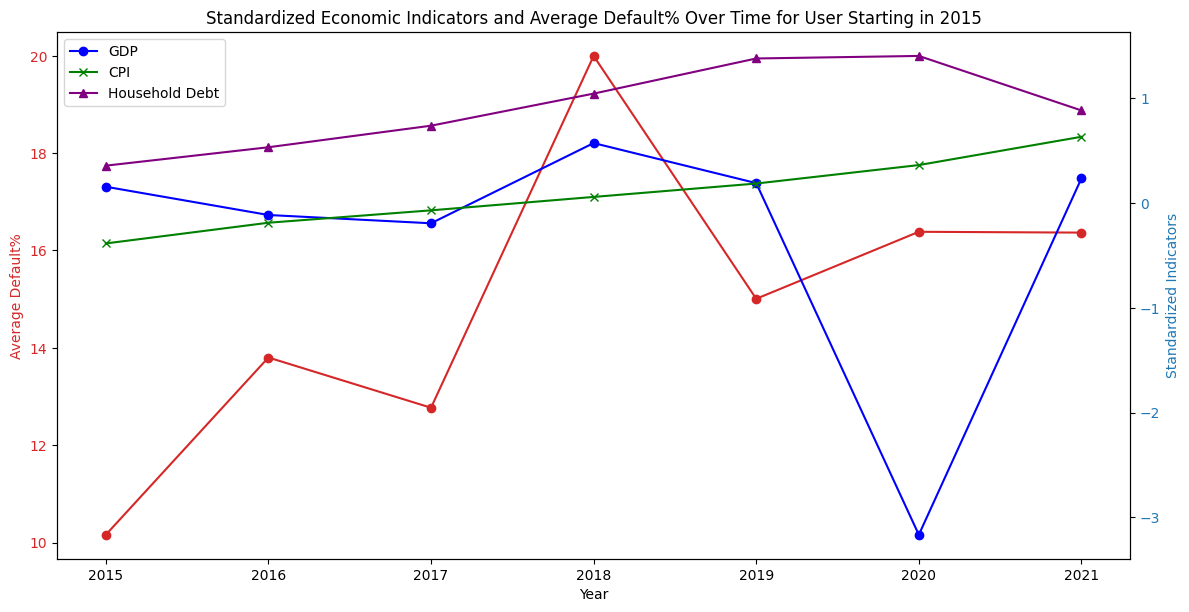

In [53]:
# Set up the plotting graph
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the first variable (Default%):
color = 'tab:red'
ax1.set_xlabel('Year')
ax1.set_ylabel('Average Default%', color=color)
ax1.plot(df_2015['YEAR'], df_2015['Average Default%'], color=color, marker='o')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second axes for the standardized indicators:
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Standardized Indicators', color=color)
ax2.plot(df_2015['YEAR'], df_2015['GDP_standardized'], label='GDP', color='blue', marker='o')
ax2.plot(df_2015['YEAR'], df_2015['CPI_standardized'], label='CPI', color='green', marker='x')
ax2.plot(df_2015['YEAR'], df_2015['Debt_standardized'], label='Household Debt', color='purple', marker='^')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Standardized Economic Indicators and Average Default% Over Time for User Starting in 2015')
ax2.legend(loc='upper left')
ax1.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.show()

In [54]:
# Defining variables
X = df_2015[["GDP_standardized", "CPI_standardized", "Debt_standardized"]]
y = df_2015["Average Default%"]

# Adding a constant to the model (for the intercept)
X = sm.add_constant(X)

# Building the OLS model
model_2015 = sm.OLS(y, X).fit()

# Print the summary of the OLS model
print(model_2015.summary())

                            OLS Regression Results                            
Dep. Variable:       Average Default%   R-squared:                       0.539
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     1.170
Date:                Fri, 19 Apr 2024   Prob (F-statistic):              0.450
Time:                        14:48:20   Log-Likelihood:                -14.655
No. Observations:                   7   AIC:                             37.31
Df Residuals:                       3   BIC:                             37.09
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                10.9269      3.85

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


# 2018

In [55]:
df_2018

,YEAR,GDP_standardized,CPI_standardized,Debt_standardized,Average Default%
12,2018,0.570839,0.057057,1.042763,7.231786
13,2019,0.188840,0.184803,1.378116,11.134319
14,2020,-3.166652,0.361007,1.402263,13.337498
15,2021,0.234152,0.630950,0.882195,16.512920


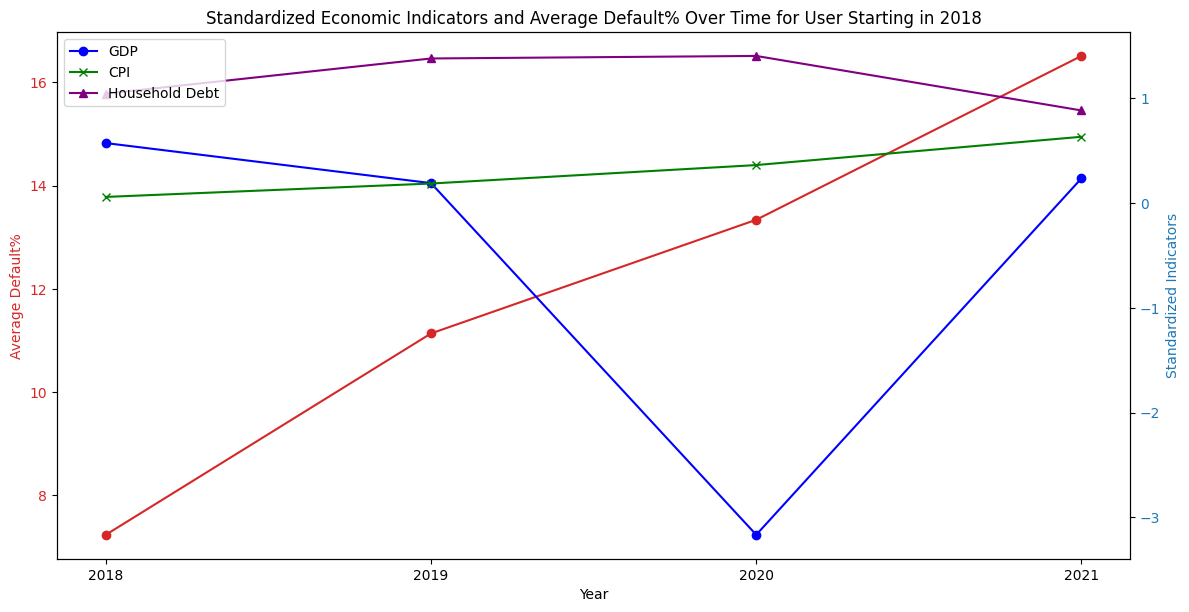

In [56]:
# Set up the plotting graph
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the first variable (Default%):
color = 'tab:red'
ax1.set_xlabel('Year')
ax1.set_ylabel('Average Default%', color=color)
ax1.plot(df_2018['YEAR'], df_2018['Average Default%'], color=color, marker='o')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second axes for the standardized indicators:
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Standardized Indicators', color=color)
ax2.plot(df_2018['YEAR'], df_2018['GDP_standardized'], label='GDP', color='blue', marker='o')
ax2.plot(df_2018['YEAR'], df_2018['CPI_standardized'], label='CPI', color='green', marker='x')
ax2.plot(df_2018['YEAR'], df_2018['Debt_standardized'], label='Household Debt', color='purple', marker='^')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Standardized Economic Indicators and Average Default% Over Time for User Starting in 2018')
ax2.legend(loc='upper left')
ax1.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.show()

In [57]:
# Defining variables
X = df_2018[["GDP_standardized", "CPI_standardized", "Debt_standardized"]]
y = df_2018["Average Default%"]

# Adding a constant to the model (for the intercept)
X = sm.add_constant(X)

# Building the OLS model
model_2018 = sm.OLS(y, X).fit()

# Print the summary of the OLS model
print(model_2018.summary())

                            OLS Regression Results                            
Dep. Variable:       Average Default%   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Fri, 19 Apr 2024   Prob (F-statistic):                nan
Time:                        14:50:56   Log-Likelihood:                 124.82
No. Observations:                   4   AIC:                            -241.6
Df Residuals:                       0   BIC:                            -244.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.6008        in

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid
